In [5]:
import tensorflow as tf
from ipywidgets import IntProgress
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
import seaborn as sns
import pandas as pd
import ptitprince as pt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
from scipy import stats

In [2]:
class CIFAR():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = []
        self._training_labels = []
        self._test_data = []
        self._test_labels = []
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
        
    
    def _load_traing_data(self):
        for i in range(1, 6):
            path = os.path.join(self._directory, "data_batch_" + str(i))
            with open(path, 'rb') as fd:
                cifar_data = pickle.load(fd, encoding = "bytes")
                imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
                imgs = imgs.transpose([0, 2, 3, 1])
                if i == 1:
                    self._training_data = imgs
                    self._training_labels = cifar_data[b"labels"]
                else:
                    self._training_data = np.concatenate([self._training_data, imgs], axis = 0)
                    self._training_labels = np.concatenate([self._training_labels, cifar_data[b"labels"]])
    
    def _load_test_data(self):
        path = os.path.join(self._directory, "test_batch")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            self._test_data = imgs.transpose([0, 2, 3, 1])
            self._test_labels = np.array(cifar_data[b"labels"])
    
    def get_training_batch(self, batch_size, numC,labelList=[]):
        if len(labelList)==0:
            return self._get_batch(self._training_data[np.where(self._training_labels<=numC)], self._training_labels[np.where(self._training_labels<=numC)], batch_size)
        else:
            return self._get_batch(self._training_data[np.where(np.isin(self._training_labels,labelList[:numC]))], self._training_labels[np.where(np.isin(self._training_labels,labelList[:numC]))], batch_size)

    def get_validation_batch(self, batch_size, numC,labelList=[]):
        if len(labelList)==0:
            return self._get_batch(self._validation_data[np.where(self._validation_labels<=numC)], self._validation_labels[np.where(self._validation_labels<=numC)], batch_size)
        else:
            return self._get_batch(self._validation_data[np.where(np.isin(self._validation_labels,labelList[:numC]))], self._validation_labels[np.where(np.isin(self._validation_labels,labelList[:numC]))], batch_size)
    
    def get_test_batch(self, batch_size,numC):
        return self._get_batch(self._test_data[np.where(self._test_labels<=numC)], self._test_labels[np.where(self._test_labels<=numC)], batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    

In [3]:
#path = "C:/Vivi's Dateien/Dropbox/"
path = "C:/Users/vivia/Dropbox/"
#path = "/Users/ingen/Dropbox/"
cifar = CIFAR(path + "Uni2/TensorFlow/Excercises/cifar-10-python/cifar-10-batches-py")

In [6]:
def printAll(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
        print(v.name)
def getNames(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v.name)
    return lst_vars
def getTensors(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
    return lst_vars
def getUnititialized(allVars):
    uninitialized_vars = []
    for var in allVars:
        try:
            session.run(var)
        except tf.errors.FailedPreconditionError:
            uninitialized_vars.append(var)
    return uninitialized_vars
def getSubSet(toFreeze,All):
    for var in toFreeze:
        All.remove(var)
    return All
def OwnAccuracyCalculator(out,target,maxOld):
    numRight = 0
    RightNew = 0
    RightOld = 0
    WrongNew = 0
    WrongOld = 0
    for i,e in enumerate(out):
        label = np.argmax(e)       
        if target[i]<maxOld:         
            if label==target[i]:
                numRight = numRight+1
                RightOld = RightOld+1
            else:
                WrongOld = WrongOld+1
        else:
            if label==target[i]:
                numRight = numRight+1
                RightNew = RightNew+1
            else:
                WrongNew = WrongNew+1            
    AccAll = numRight/out.shape[0]
    AccOld = RightOld/(RightOld+WrongOld)
    try:
        AccNew = RightNew/(RightNew+WrongNew)
    except:
        AccNew = 0
    return AccAll,AccOld,AccNew
def smoothListGaussian(list,strippedXs=False,degree=5):  
    #Code from https://www.swharden.com/wp/2008-11-17-linear-data-smoothing-in-python/
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    for i in range(len(smoothed)):
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
    return smoothed
def perfQuantifier(accs,esteps,smooth=True):
    if smooth:
        smoothacc = smoothListGaussian(accs,degree=20)
    else:
        smoothacc = accs
    numEpochs = esteps.shape[0]
    plateauStart = np.zeros((esteps.shape[0]-1))
    pleateau = np.zeros((esteps.shape[0]-1))
    mins = np.zeros((esteps.shape[0]-1))
    for i in range(numEpochs-1):
        part = smoothacc[esteps[i]:esteps[i+1]]
        tenpermax = max(part)-0.02#plateau starts when max-2% is reached
        #max(part)-(max(part)-min(part))/4#get threshold of 10% below maximum
        pleateau[i] = tenpermax
        plateauStart[i] = np.where(part>tenpermax)[0][0]
        mins[i] = np.min(accs[esteps[i]:esteps[i+1]])
    return plateauStart,pleateau,mins
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z))).T
    return sm

## Multirun Training

Adjust variables everywhere where you find comments to run different conditions. The default code runs a normal network training on CIFAR-10 for 5 epochs 100 times. You can change:
* Number of experiments (now 100)
* Number of epochs in each block (now 1)
* Number of new classes/blocks (now 5)
* Batch size (now 200)
* Number of classes and output nodes the network starts with (now both 10)
* Number of new classes introduced in each block (now 0)
* Random class introduction (now false) or increasing/decreasing class difficulty
* If the first or first&second convolutional layer gets frozen after the first block (now False)
* The optimizer (Now Adam)
* The new weight initialization when growing the last layer (Now old weight initialization)
* Number of epochs of training after the last class has been introduced (Now 0)

In [6]:
numExperiments = 100
epochs = 1 #Number of epochs in each block (how often is the training set itterated before a new class is added)
newClasses = 5 #Number of new classes introduced
KeepTrain = 0 #Number of blocks after last class introduction

mini_batch_size = 200
plot_step_size = 50
training_steps = cifar.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
validation_cross_entropies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))

training_accuracies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
training_accuracies_old = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
training_accuracies_new = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
validation_accuracies = np.zeros((training_steps * epochs * (newClasses+KeepTrain),numExperiments))
testaccs = np.zeros(numExperiments)
#allOuts = []
#allTargets = []
#testOrders = []

ESteps = [0]

exN = IntProgress(min=0, max=numExperiments) # instantiate the bar
display(exN) # display the bar

for exp in range(numExperiments):
    Llist = np.linspace(0,9,10)
    #Llist = np.random.permutation(10)#use random permutation for random class order in continuous learning
    #testOrders.append(Llist) #To save different orders and compare network performance on them
    #Llist = [8,1,6,7,0,9,5,4,2,3]# introduce classes in increasing difficulty
    #Llist = [3,2,4,5,9,0,7,6,1,8]# introduce classes in decreasing difficulty
    #print(Llist)
    numC=10 #Number of classes in the beginning of training
    #-----------------------------------------------------------
    numOutP=10 #Number of classes at the beginning of training
    outName = 'LastLayer/add:0'
    tf.reset_default_graph()
    
    weightName = 'LastLayer/weights_4'+str(numOutP)+':0'
    x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
    desired = tf.placeholder(tf.int64, shape = [None])

    normx = tf.layers.batch_normalization(x)

    with tf.variable_scope("model",reuse=tf.AUTO_REUSE):

        kernels_1 = tf.get_variable("kernels_1",shape=[5, 5, 3,16],initializer=tf.truncated_normal_initializer(stddev = 0.1))
        convolution_1 = tf.nn.conv2d(normx, kernels_1, strides = [1, 1, 1,1], padding = "SAME", name="convolution_1")

        biases_1 = tf.get_variable("biases_1",[16],initializer=tf.constant_initializer(0.0))
        feature_maps_1 = tf.nn.tanh(convolution_1 + biases_1, name="feature_maps_1")

        pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_1")

        kernels_2 = tf.get_variable("kernels_2",[3, 3, 16, 32],initializer=tf.truncated_normal_initializer(stddev = 0.1))
        convolution_2 = tf.nn.conv2d(tf.layers.batch_normalization(pool_1), kernels_2, strides = [1, 1, 1, 1], padding = "SAME", name="convolution_2")

        biases_2 = tf.get_variable("biases_2",[32],initializer=tf.constant_initializer(0.0))
        feature_maps_2 = tf.nn.tanh(convolution_2 + biases_2, name="feature_maps_2")

        pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_2")

        flattened = tf.reshape(tf.layers.batch_normalization(pool_2), [-1, 8 * 8 * 32], name="flattened")

        startVars2 = getTensors(tf.global_variables())

        weights_3 = tf.get_variable("weights_3",[2048, 512],initializer=tf.truncated_normal_initializer(stddev = 1568**(-1/2)))
        biases_3 = tf.get_variable("biases_3",[512],initializer=tf.constant_initializer(0.0))
        hidden_layer = tf.nn.tanh(tf.matmul(flattened, weights_3) + biases_3, name="hidden_layer")
    #startVars2 = getTensors(tf.global_variables()) # uncomment to only retrain last layer
    startVars = getTensors(tf.global_variables())
    def newLast(hiddenIn,numOut):
        with tf.variable_scope("LastLayer",reuse=False):
            weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.truncated_normal_initializer(stddev = 512**(-1/2)))
            #weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.constant_initializer(0.01))
            biases_4 = tf.get_variable('biases_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
            output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
        return output_layer_logits,weights_4

    def newLastInit(hiddenIn,numOut,init):
        with tf.variable_scope("LastLayerInit",reuse=False):
            weights_4 = tf.get_variable('weightsI_4'+str(numOut),[512,numOut],initializer=init)
            biases_4 = tf.get_variable('biasesI_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
            output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
        return output_layer_logits,weights_4

    def evaluate(outLogs,desired):    
        with tf.variable_scope("eval",reuse=tf.AUTO_REUSE):
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = outLogs)
            accuracy = tf.equal(tf.argmax(tf.nn.softmax(outLogs), 1), desired)

        return accuracy,cross_entropy

    with tf.variable_scope(tf.get_variable_scope()):
        outLog,w4 = newLast(hidden_layer,numOutP)
        acc,CE = evaluate(outLog,desired)

    accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
    cross_entropy = tf.reduce_mean(CE)

    learning_rate = 1e-4
    optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')
    training_step = optimizer.minimize(cross_entropy)
    gradient = tf.gradients(cross_entropy, w4)[0]

    #startVars = getTensors(tf.global_variables())
    DontFreezeList = getSubSet(startVars2,startVars)

    #-------------------------------------------------
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        session.run(tf.global_variables_initializer())
        step = 0
        for nC in range(newClasses + KeepTrain):             
            last_step = False
            if nC>100:# no growing -> condition thats never fulfilled or delete this block
            #if (nC>0) & (nC<newClasses):#if the last layer should progressively grow
                DontFreezeList = getSubSet(newVars,DontFreezeList)#Exclude last layer from previous epoch
                initializer = tf.constant_initializer(np.append(weights,np.random.choice(weights.flatten(),(512,1)),axis=1))
                with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
                    outLog,Wname = newLastInit(hidden_layer,numOutP,initializer)
                    acc,CE = evaluate(outLog,desired)
                    accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
                    cross_entropy = tf.reduce_mean(CE)
                    learning_rate = 1e-4
                    optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')

                weightName = Wname
                gradient = tf.gradients(cross_entropy, weightName)[0]
                newVars = getUnititialized(tf.all_variables())
                DontFreezeList = np.append(DontFreezeList,newVars,axis=0).tolist()
                #training_step = optimizer.minimize(cross_entropy, var_list=DontFreezeList)#Only train part of network
                training_step = optimizer.minimize(cross_entropy)#keep training all
                uninitialized_vars = getUnititialized(tf.all_variables())
                init_new_vars_op = tf.initialize_variables(uninitialized_vars)
                session.run(init_new_vars_op)
            else:
                newVars = []
            s = 0
            for epoch in range(epochs):
                for images, labels in cifar.get_training_batch(mini_batch_size,numC-1,Llist):            
                    if s == 0:
                        training_cross_entropies[step,exp], training_accuracies[step,exp],FirstOut,Firstweights,Firstgrad = session.run(
                        [cross_entropy, accuracy, outLog,weightName,gradient],feed_dict ={x: images, desired: labels}
                    )
                        FirstL = labels
                    s = s+1
                    training_cross_entropies[step,exp], training_accuracies[step,exp], _ ,trainOut= session.run(
                        [cross_entropy, accuracy, training_step,outLog],feed_dict ={x: images, desired: labels}
                    )
                    Aall,old,new = OwnAccuracyCalculator(trainOut,labels,numC-1)
                    training_accuracies_old[step,exp] = old               
                    training_accuracies_new[step,exp] = new
                    #allOuts.append(trainOut)
                    #allTargets.append(labels)
                    if step == (training_steps * epochs * newClasses)-(training_steps+4):
                        last_step = True

                    if step % plot_step_size == 0 or last_step:
                        images, vlabels = next(cifar.get_validation_batch(0,numC-1),Llist)

                        validation_cross_entropy, validation_accuracy,out,weights,grad= session.run(
                            [cross_entropy, accuracy,outLog,weightName,gradient],
                            feed_dict = {x: images, desired: vlabels}
                        )

                        if step != 0:
                            on = step - plot_step_size if not last_step else step - plot_step_size + 1
                            off = on + plot_step_size
                            validation_cross_entropies[on:off,exp] = [validation_cross_entropy] * plot_step_size
                            validation_accuracies[on:off,exp] = [validation_accuracy] * plot_step_size
                    step += 1
            #numC = numC+1 #increase number of classes in the dataset
            #numOutP = numOutP +1 #increase number of output neurons
            ESteps = np.append(ESteps,step)
            
            #n=n+1
        images, testlabels =next(cifar.get_test_batch(0,numC-1))
        testaccs[exp],grad= session.run([accuracy,gradient],feed_dict = {x: images, desired: testlabels})
        exN.value += 1

IntProgress(value=0)

### Plot 100 Runs

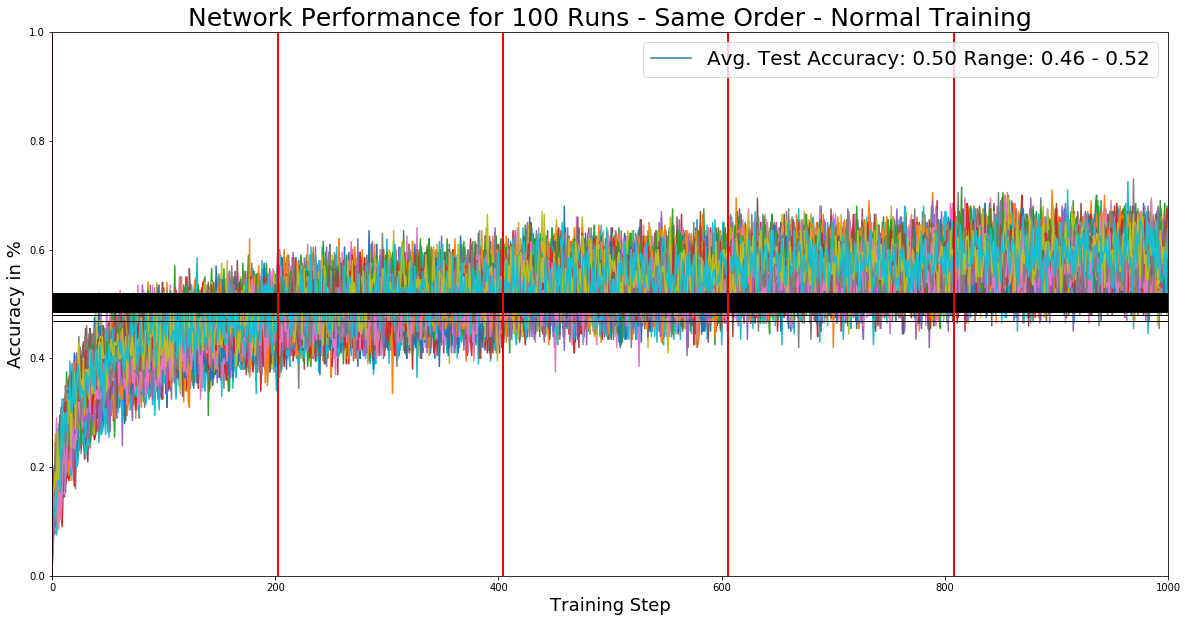

In [12]:
normalTestAccs = testaccs
plt.figure(figsize=(20,10))
for e in range(numExperiments):
    plt.plot(training_accuracies.T[e])   
for e in range(numExperiments):
    plt.plot(np.full(ESteps[-1],testaccs[e]), linewidth=1, color = 'black')
    #plt.plot(validation_accuracies.T[e],color='orange') #plot validation accuracies as well    
plt.legend(['Avg. Test Accuracy: '+str(np.mean(testaccs))[:4]+" Range: "+str(min(testaccs))[:4]+" - "+str(max(testaccs))[:4]],fontsize=20)
plt.xlabel("Training Step", fontsize=18)
plt.ylabel("Accuracy in %", fontsize=18)
plt.title("Network Performance for 100 Runs - Same Order - Normal Training", fontsize=25)
plt.xlim(0,ESteps[-1]-10)
plt.ylim(0,1)
for e in ESteps:
    plt.axvline(x=e,color='r')
plt.show()
#plt.savefig("NewResults/CIFAR_Normal_NoShuffle100.png", bbox_inches='tight')

### Save Data

In [13]:
np.save('RawData/CIFAR-10_100x_Normal_Train.npy',training_accuracies)
np.save('RawData/CIFAR-10_100x_Normal_Val.npy',validation_accuracy)
np.save('RawData/CIFAR-10_100x_Normal_Test.npy',testaccs)

## Data Analysis
Run the above code under all conditions you need and save at least the test accuracies. Then you can sort your test accuracies into a data frame and perform some statistics on it. Here I will just load the data I collected and orderd.

In [71]:
testaccs = pd.read_csv('NewResults/TestAccuracies.csv')[['Condition','Freeze','KeepTrain','Performance']]

### Weight Initialization Comparison

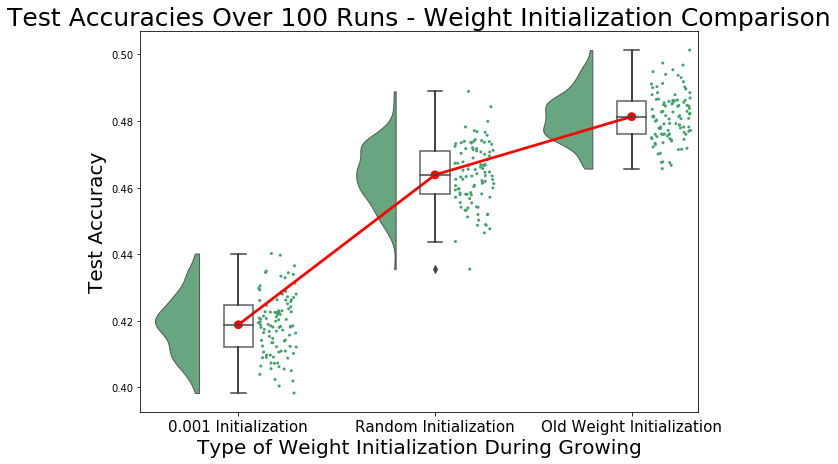

In [33]:
PerComp = testaccs[(testaccs['Condition']=='Random Initialization')|(testaccs['Condition']=='0.001 Initialization')|(testaccs['Condition']=='Old Weight')]
ax = pt.RainCloud(data=PerComp, x='Condition',y='Performance',palette=sns.xkcd_palette(["greenish"]),bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = True, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["0.001 Initialization",'Random Initialization','Old Weight Initialization'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Weight Initialization Comparison',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Type of Weight Initialization During Growing",fontsize=20)
plt.show()
#plt.savefig("NewResults/PerfComp100xWeightInit.png", bbox_inches='tight')

In [25]:
test = PerComp
print("0.001 Initialization - Random Initialization:" +str(stats.ttest_rel(test[test['Condition']=='0.001 Initialization']['Performance'],test[test['Condition']=='Random Initialization']['Performance'])))
print("0.001 Initialization - Old Weight:" +str(stats.ttest_rel(test[test['Condition']=='0.001 Initialization']['Performance'],test[test['Condition']=='Old Weight']['Performance'])))
print("Random Initialization - Old Weight:" +str(stats.ttest_rel(test[test['Condition']=='Random Initialization']['Performance'],test[test['Condition']=='Old Weight']['Performance'])))


0.001 Initialization - Random Initialization:Ttest_relResult(statistic=-36.73934872526554, pvalue=1.707676983102839e-59)
0.001 Initialization - Old Weight:Ttest_relResult(statistic=-52.924022672029444, pvalue=2.0230762728777505e-74)
Random Initialization - Old Weight:Ttest_relResult(statistic=-13.856540889621368, pvalue=6.487749407414894e-25)


### Compare Conditions + Training Duration

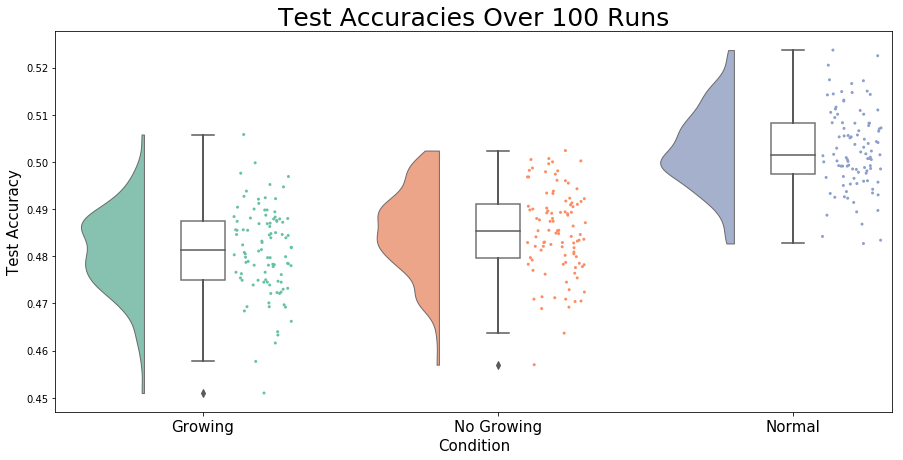

In [34]:
testaccDF = testaccs[(testaccs['Freeze']=='No Freeze')&(testaccs['KeepTrain']==0)].reset_index().loc[:299]
ax = pt.RainCloud(data=testaccDF, x='Condition',y='Performance',palette="Set2",bw = 0.3,
                 width_viol = .5, figsize = (15,7),pointplot = False, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["Growing","No Growing", "Normal"],fontsize=15)
plt.title('Test Accuracies Over 100 Runs',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=15)
plt.xlabel("Condition",fontsize=15)
plt.show()
#plt.savefig("NewResults/PerfComp100xDistFreeze.png", bbox_inches='tight')

In [44]:
mod = ols('Performance ~ Condition',
                data=testaccDF).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df           F        PR(>F)
Condition  0.026000    2.0  163.599439  1.255653e-48
Residual   0.023601  297.0         NaN           NaN


In [45]:
test = testaccDF
print("Grow - No Grow:" +str(stats.ttest_rel(test[test['Condition']=='Grow']['Performance'],test[test['Condition']=='NoGrow']['Performance'])))
print("Grow - Normal:" +str(stats.ttest_rel(test[test['Condition']=='Grow']['Performance'],test[test['Condition']=='Normal']['Performance'])))
print("Normal - No Grow:" +str(stats.ttest_rel(test[test['Condition']=='Normal']['Performance'],test[test['Condition']=='NoGrow']['Performance'])))

Grow - No Grow:Ttest_relResult(statistic=-3.095932192137419, pvalue=0.0025518911764033053)
Grow - Normal:Ttest_relResult(statistic=-16.869788602044423, pvalue=7.061405788781368e-31)
Normal - No Grow:Ttest_relResult(statistic=13.274422146872034, pvalue=1.0423179611336904e-23)


#### Compare Performance Improvement with Longer Training

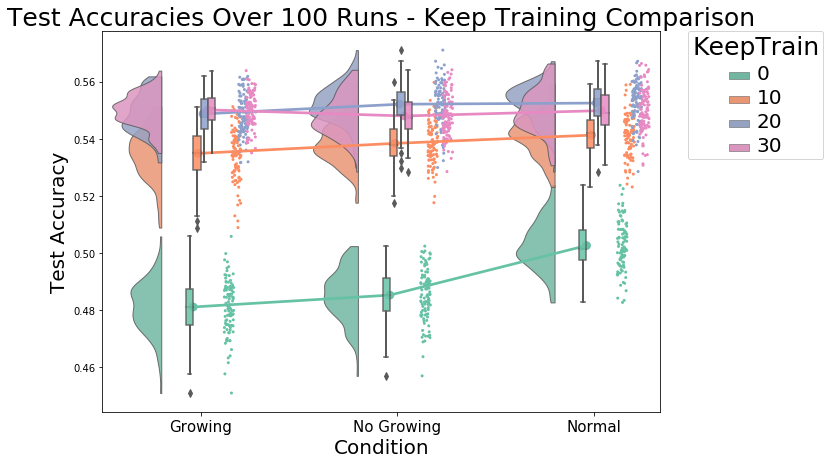

In [72]:
testDF = testaccs[((testaccs['Condition']=='Normal')|(testaccs['Condition']=='Grow')|(testaccs['Condition']=='NoGrow'))&(testaccs['Freeze']=='No Freeze')]

ax = pt.RainCloud(data=testDF, hue='KeepTrain',x='Condition',y='Performance',palette="Set2",bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = True, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["Growing",'No Growing','Normal'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Keep Training Comparison',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.show()
#plt.savefig("NewResults/PerfComp100xDistKeepTrain30.png", bbox_inches='tight')

#### Significant difference between conditions after 30 epochs of post training?

In [50]:
mod = ols('Performance ~ Condition',
                data=testDF[(testDF['KeepTrain']==30)]).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df        F    PR(>F)
Condition  0.000273    2.0  2.83794  0.060135
Residual   0.014307  297.0      NaN       NaN


### Compar Freezing Conditions

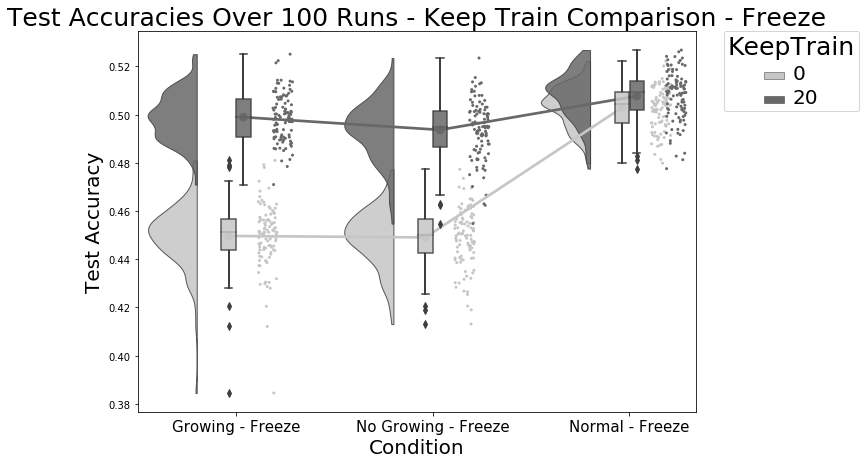

In [36]:
testDF = testaccs[((testaccs['Condition']=='Normal')|(testaccs['Condition']=='Grow')|(testaccs['Condition']=='NoGrow'))&(testaccs['Freeze']=='Freeze')]
ax = pt.RainCloud(data=testDF, hue='KeepTrain',x='Condition',y='Performance',palette="Greys",bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = True, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["Growing - Freeze",'No Growing - Freeze','Normal - Freeze'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Keep Train Comparison - Freeze',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.show()
#plt.savefig("NewResults/PerfComp100xDistKeepTrainCompFreezeGrey.png", bbox_inches='tight')

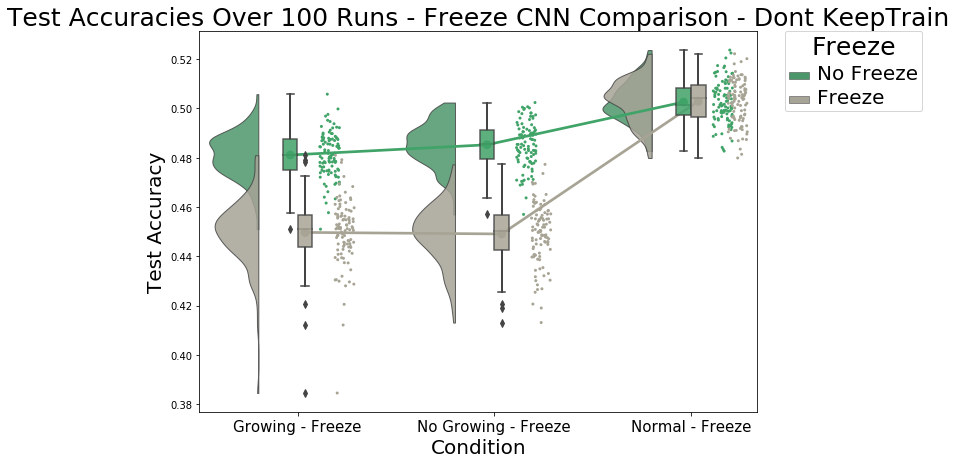

In [37]:
testDF = testaccs[((testaccs['Condition']=='Normal')|(testaccs['Condition']=='Grow')|(testaccs['Condition']=='NoGrow'))&(testaccs['KeepTrain']==0)]

ax = pt.RainCloud(data=testDF, hue='Freeze',x='Condition',y='Performance',palette=sns.xkcd_palette(["greenish","greyish"]),bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = True, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["Growing - Freeze",'No Growing - Freeze','Normal - Freeze'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Freeze CNN Comparison - Dont KeepTrain',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.show()
#plt.savefig("NewResults/PerfComp100xDistKeepTrain0FreezeGrey.png", bbox_inches='tight')

In [55]:
mod = ols('Performance ~ Condition + Freeze',
                data=testDF).fit()              
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df           F         PR(>F)
Condition  0.177744    2.0  514.531419  1.527841e-130
Freeze     0.075479    1.0  436.992802   3.329299e-73
Residual   0.102944  596.0         NaN            NaN


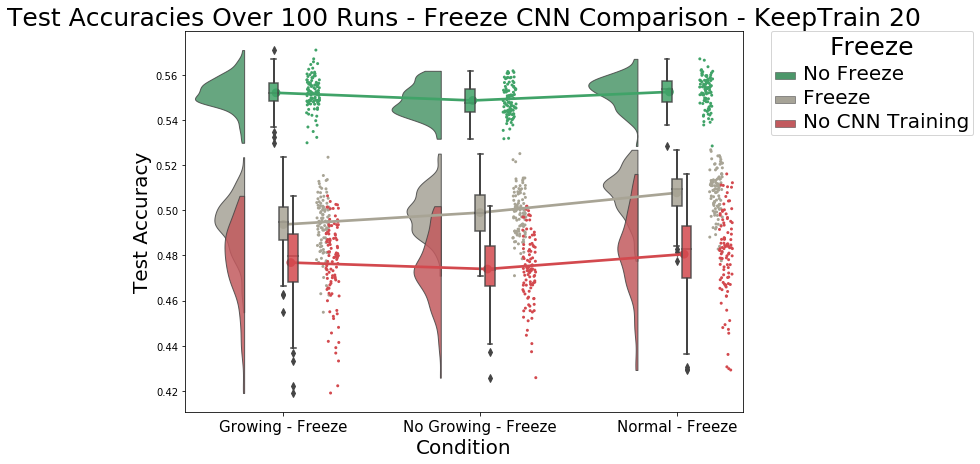

In [73]:
testDF = testaccs[((testaccs['Condition']=='Normal')|(testaccs['Condition']=='Grow')|(testaccs['Condition']=='NoGrow'))&(testaccs['KeepTrain']==20)]

ax = pt.RainCloud(data=testDF, hue='Freeze',x='Condition',y='Performance',palette=sns.xkcd_palette(["greenish","greyish","faded red"]),bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = True, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["Growing - Freeze",'No Growing - Freeze','Normal - Freeze'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Freeze CNN Comparison - KeepTrain 20',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.show()
#plt.savefig("NewResults/PerfComp100xDistKeepTrain20CNNTrain.png", bbox_inches='tight')

In [58]:
#For models trained with 20 epochs of post training
mod = ols('Performance ~ Condition + Freeze',
                data=testDF).fit()               
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df            F        PR(>F)
Condition  0.007758    2.0    24.236938  5.612901e-11
Freeze     0.859406    2.0  2684.879748  0.000000e+00
Residual   0.143241  895.0          NaN           NaN


In [59]:
#Difference between conditions with no CNN training?
mod = ols('Performance ~ Condition',
                data=testDF[(testDF['Freeze']=='No CNN Training')]).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df        F    PR(>F)
Condition  0.002188    2.0  3.69167  0.026081
Residual   0.088029  297.0      NaN       NaN


In [60]:
#Difference between conditions for frozen CNN?
mod = ols('Performance ~ Condition',
                data=testDF[(testDF['Freeze']=='Freeze')]).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df          F        PR(>F)
Condition  0.010055    2.0  42.464127  6.026114e-17
Residual   0.035163  297.0        NaN           NaN


In [61]:
#Difference between conditions + differences between no cnn training and full network training
mod = ols('Performance ~ Condition + Freeze',
                data=testDF[(testDF['Freeze']!='No Freeze')]).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df           F        PR(>F)
Condition  0.009298    2.0   21.967624  6.235166e-10
Freeze     0.079477    1.0  375.526556  3.028925e-65
Residual   0.126138  596.0         NaN           NaN


### Training Order/Learning Scheduling

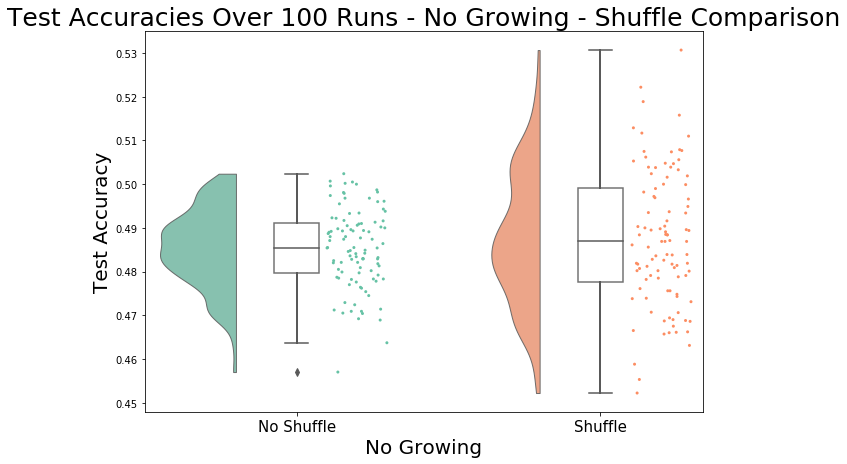

In [80]:
testDF = testaccs[((testaccs['Condition']=='NoGrow')&(testaccs['KeepTrain']==0)&(testaccs['Freeze']=='No Freeze'))|(testaccs['Condition']=='Shuffle')]

ax = pt.RainCloud(data=testDF, x='Condition',y='Performance',palette="Set2",bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = False, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["No Shuffle","Shuffle"],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - No Growing - Shuffle Comparison',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("No Growing",fontsize=20)
plt.show()
#plt.savefig("NewResults/PerfComp100xDistShuffleComp2.png", bbox_inches='tight')

#### Investigate the Class Order in the Best Runs

In [8]:
#GoodOrder = np.array(testOrders)[testaccs>0.5]
#or:
GoodOrder = np.load('GoodOrder.npy')
EndAccs = np.array([0.63109563, 0.732708  , 0.47086243, 0.45209758, 0.47370699,
       0.47074511, 0.73162655, 0.66725988, 0.72977786, 0.56412975])# Class accuracies at end of training

In [9]:
goodorderDF = pd.DataFrame(columns = {'Class','EndAcc','OrderPos'})
for g in GoodOrder:
    for i,c in enumerate(g):
        goodorderDF = goodorderDF.append({'Class':c,'EndAcc':EndAccs[c],'OrderPos':(i)},ignore_index=True)

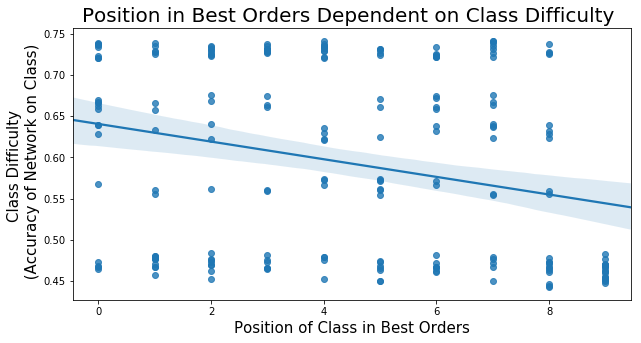

In [10]:
plt.figure(figsize=(10,5))
sns.regplot(x="OrderPos", y="EndAcc", data=goodorderDF, y_jitter=.01);
plt.title("Position in Best Orders Dependent on Class Difficulty ",fontsize=20)
plt.xlabel("Position of Class in Best Orders",fontsize=15)
plt.ylabel("Class Difficulty \n (Accuracy of Network on Class)",fontsize=15)
plt.show()
#plt.savefig("NewResults/ClassOrder-Difficulty.png", bbox_inches='tight')

In [11]:
mod = ols('EndAcc ~ OrderPos',
                data=goodorderDF).fit()               
aov_table = sm.stats.anova_lm(mod, typ=1)
print(mod.summary())
print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                 EndAcc   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     16.43
Date:                Tue, 06 Nov 2018   Prob (F-statistic):           7.14e-05
Time:                        16:00:46   Log-Likelihood:                 166.66
No. Observations:                 210   AIC:                            -329.3
Df Residuals:                     208   BIC:                            -322.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6406      0.014     45.426      0.0

In [12]:
scipy.stats.pearsonr(goodorderDF['OrderPos'], goodorderDF['EndAcc'])

(-0.2705549994050498, 7.137981812607356e-05)

#### Compare Increasing to Decreasing Difficulty

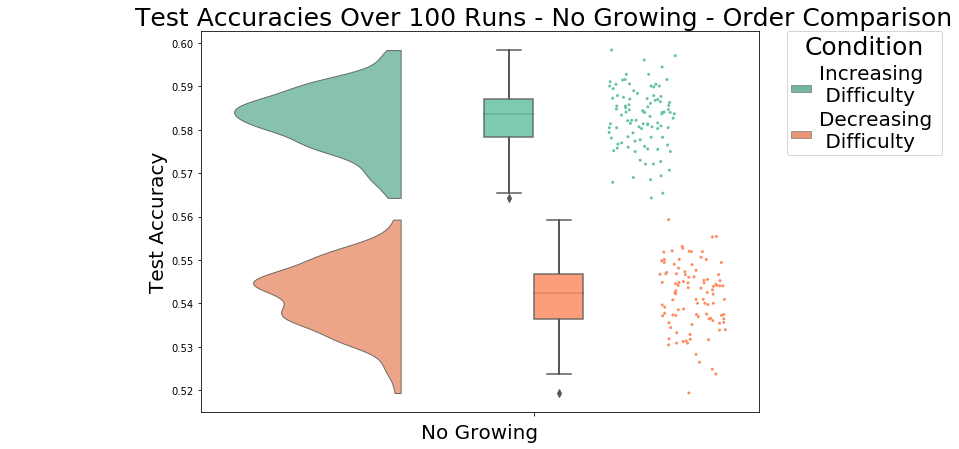

In [39]:
testDF = testaccs[(testaccs['Condition']=='Increasing \n Difficulty')|(testaccs['Condition']=='Decreasing \n Difficulty')]
ax = pt.RainCloud(data=testDF, hue='Condition',x='KeepTrain',y='Performance',palette="Set2",bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = False, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels("",fontsize=15)
plt.title('                Test Accuracies Over 100 Runs - No Growing - Order Comparison',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("No Growing",fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.show()
#plt.savefig("NewResults/PerfComp100xDistOrder.png", bbox_inches='tight')

In [42]:
mod = ols('Performance ~ Condition',
                data=testDF).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df            F        PR(>F)
Condition  0.084378    1.0  1586.683213  1.752367e-96
Residual   0.010529  198.0          NaN           NaN


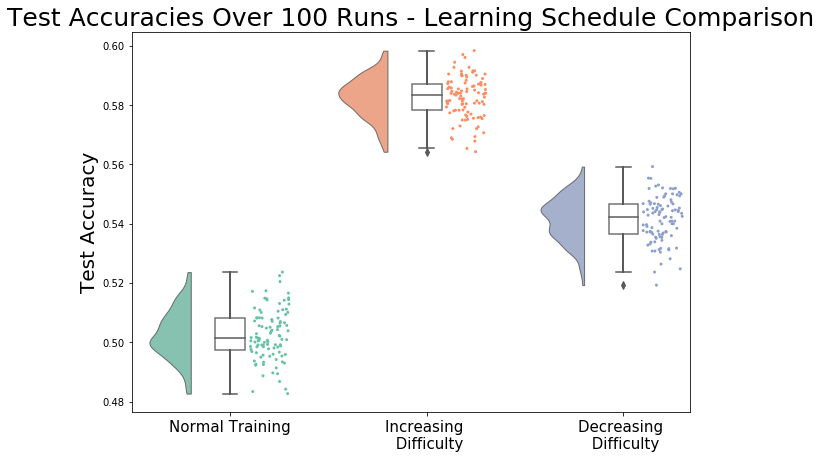

In [56]:
testDF = testaccs[(testaccs['Condition']=='Increasing \n Difficulty')|(testaccs['Condition']=='Decreasing \n Difficulty')|((testaccs['Condition']=='Normal')&(testaccs['KeepTrain']==0)&(testaccs['Freeze']=='No Freeze'))]

ax = pt.RainCloud(data=testDF, x='Condition',y='Performance',palette="Set2",bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = False, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(['Normal Training','Increasing \n Difficulty','Decreasing \n Difficulty'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Learning Schedule Comparison',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("",fontsize=20)
plt.show()
#plt.savefig("NewResults/PerfComp100xSchedule.png", bbox_inches='tight')

In [59]:
#Increasing difficulty significantly better than normal training?
testDF = testaccs[(testaccs['Condition']=='Increasing \n Difficulty')|((testaccs['Condition']=='Normal')&(testaccs['KeepTrain']==0)&(testaccs['Freeze']=='No Freeze'))]
mod = ols('Performance ~ Condition',
                data=testDF).fit()              
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

             sum_sq     df            F         PR(>F)
Condition  0.319984    1.0  5304.329467  6.556581e-145
Residual   0.011944  198.0          NaN            NaN


### Catastrophic Forgetting

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\kde.py:513: RuntimeWarning: divide by zero encountered in true_divide
  self.inv_cov = self._data_inv_cov / self.factor**2
c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\kde.py:224: RuntimeWarning: invalid value encountered in true_divide
  result = result / self._norm_factor
c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


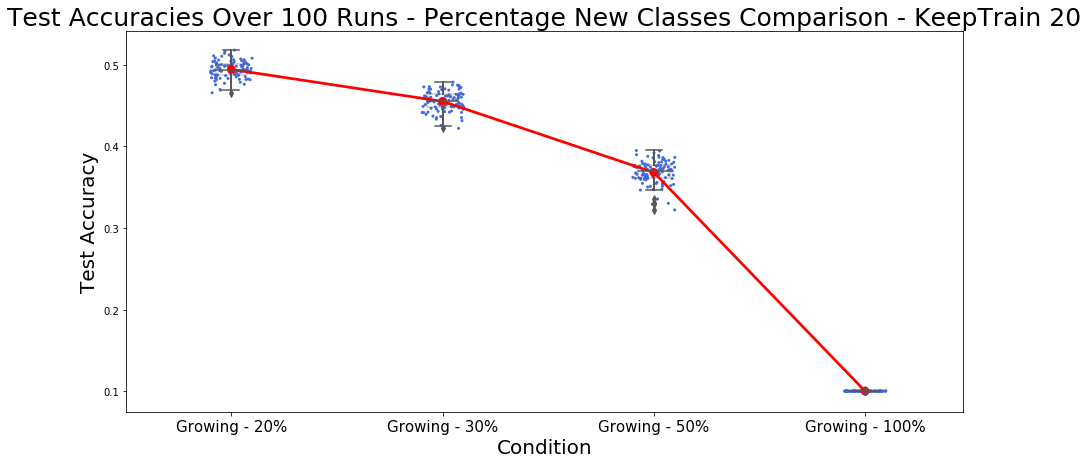

In [67]:
PerComp = testaccs[(testaccs['Condition']=='Grow - 20%')|(testaccs['Condition']=='Grow - 30%')|(testaccs['Condition']=='Grow - 50%')|(testaccs['Condition']=='Grow - 100%')]
ax = pt.RainCloud(data=PerComp, x='Condition',y='Performance', palette=["royalblue"],bw = 0.0,
                 width_viol = .0, figsize = (15,7),pointplot=True,alpha = 0.3, dodge = True, move = 0.0)
ax.set_xticklabels(["Growing - 20%",'Growing - 30%','Growing - 50%','Growing - 100%'],fontsize=15)
plt.title('Test Accuracies Over 100 Runs - Percentage New Classes Comparison - KeepTrain 20',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.show()
#plt.savefig("NewResults/PerfComp100xPercentage.png", bbox_inches='tight')

#### Freezing Agains Catastrophic Forgetting?

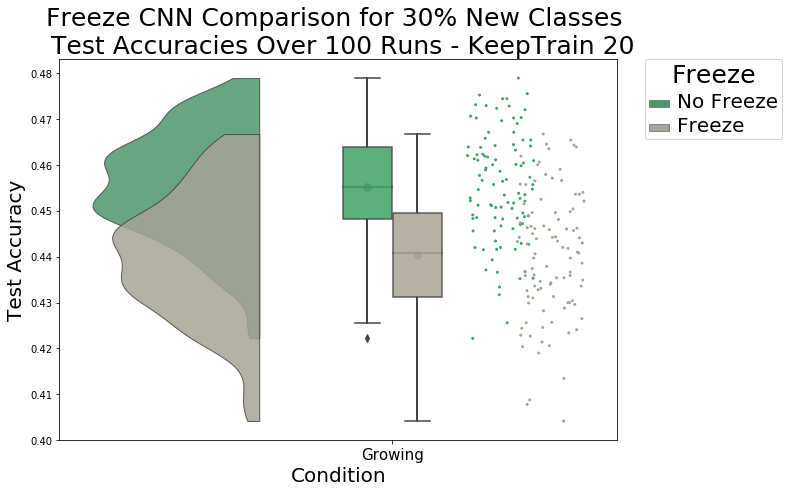

In [66]:
ax = pt.RainCloud(data=testaccs[(testaccs['Condition']=='Grow - 30P')], hue='Freeze',x='Condition',y='Performance',palette=sns.xkcd_palette(["greenish","greyish"]),bw = 0.3,
                 width_viol = .5, figsize = (10,7),pointplot = True, alpha = .85, dodge = True, move = 0.2)
ax.set_xticklabels(["Growing"],fontsize=15)
plt.title('Freeze CNN Comparison for 30% New Classes \n Test Accuracies Over 100 Runs - KeepTrain 20',fontsize=25)
plt.ylabel('Test Accuracy',fontsize=20)
plt.xlabel("Condition",fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.show()
#plt.savefig("NewResults/PerfComp100xDistKeepTrain20_30PFreeze.png", bbox_inches='tight')

In [70]:
mod = ols('Performance ~ Freeze',
                data=testaccs[testaccs['Condition']=='Grow - 30P']).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

            sum_sq     df          F        PR(>F)
Freeze    0.011103    1.0  68.210656  2.066283e-14
Residual  0.032231  198.0        NaN           NaN
